In [1]:
# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch
import random
import time
import os
import gym
import tqdm

# import Koopman Libraries
from core.koopman_core_linear import KoopDNN_linear, KoopmanNet_linear, KoopmanNetCtrl_linear
from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift

# drone_dynamics
from dynamics.quadsim_2d import QuadSim

# Import Adaptive Koopman
from core.adapt_net_linear import AdaptNet_linear
import scipy.io
import scipy.integrate as integrate 

In [2]:
# base
train = False
gen_paths = False

In [3]:
# quad pars # curently not in play
quad_params = {}
quad_params['m'] = 2
quad_params["g"] = 9.81
quad_params["L"] = 0.2
quad_params['Ixx'] = 1 #0.02


# quad_params = {}
# quad_params['m'] = 0.8
# quad_params["g"] = 9.81
# quad_params["L"] = 0.5
# quad_params['Ixx'] = quad_params['m']*(quad_params["L"]**2)/12 #1

# quad parameters changed
per_change = 50
quad_params_changed = {}
quad_params_changed['m'] =  2.4 #affects z
quad_params_changed['Ixx'] = 1.2 #1 # affects yaw
quad_params_changed["g"] = 9.81
quad_params_changed["L"] = 0.2 # at this point doesn't affect much because it is decoupled from Inertia but very potent
# quad_params_changed = {}
# quad_params_changed['m'] = 0.8
# quad_params_changed["g"] = 9.81
# quad_params_changed["L"] = 0.5
# quad_params_changed['Ixx'] = quad_params['m']*(quad_params["L"]**2)/12 #1

In [4]:
quad_params_changed['m'],  quad_params_changed['Ixx']

(2.4, 1.2)

In [5]:
0.5/0.04

12.5

In [6]:
# load drone
env = QuadSim(quad_params)
env_changed = QuadSim(quad_params_changed)


# data generation parameters
dt = env.dt
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val
num_snaps = 200*3 #1000-> 5sec of data ... (1000/200)
num_states = 6
num_inputs = 2
T = np.linspace(0,num_snaps*dt,num_snaps+1)

8.467743866766712
8.920005596141701


/home/rajpal/.local/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
# generate data
if gen_paths:
    X = np.empty((num_traj,num_snaps+1,num_states)) # cartesian state matrix
    # X_des = np.empty((num_traj,num_snaps,num_states)) # cartesian state matrix
    U = np.empty((num_traj,num_snaps,num_inputs)) # input matrix
    curr_state = []
    # curr_state_noise = []
    des_state = []
    action_plt = []
    for i in tqdm.tqdm(range(num_traj)):
        obs = env.reset()
        done = False
        
        # with open("/home/rajpal/koopman/linear_drone_koopman/Trajectory/traj_{}.csv".format(i+1), "w") as f:
        #     f.write("t,x,y,z,roll,pitch,yaw,vx,vy,vz,roll_rate,pitch_rate,yaw_rate,U,Mx,My,Mz\n")
             # X[i,0,:] = env.Quadrotor.get_state()
    #         print(X[i,0,0],X[i,0,1],X[i,0,2],X[i,0,3],X[i,0,4],X[i,0,5],X[i,0,6],X[i,0,7],X[i,0,8],X[i,0,9],X[i,0,10],X[i,0,11])
            # f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(env.t, X[i,0,0], X[i,0,1], X[i,0,2], X[i,0,3], X[i,0,4], X[i,0,5], X[i,0,6], X[i,0,7], X[i,0,8], X[i,0,9], X[i,0,10], X[i,0,11]))
    
        for j in range(num_snaps):
            action = env.action_space.sample()
            #env.render()\n",  
            #action, _states = model.predict(obs)
    #             U[i,j,:] = action[0], action[1]
            obs, reward, done, info = env.step(action)
            if j == 0:
                X[i,j,:] = env.Quadrotor.get_state()
            des_state = env.get_des_state()
            # curr_state.append(state)
            # curr_state_noise.append(state)
            # des_state.append(env.get_des_state())
            action_plt.append(env.get_action())
            # #print(action)\n",
            # print(env.get_action().reshape(-1))
            U[i,j,:] = env.get_action()#.reshape(-1)
            X[i,j+1,:] = env.Quadrotor.get_state()
            # X_des[i,j+1,:] = des_state[:6]
            # f.write("{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(env.t, X[i,j+1,0], X[i,j+1,1], X[i,j+1,2], X[i,j+1,3], X[i,j+1,4], X[i,j+1,5], X[i,j+1,6], X[i,j+1,7], X[i,j+1,8], X[i,j+1,9], X[i,j+1,10], X[i,j+1,11], U[i,j,0], U[i,j,1], U[i,j,2], U[i,j,3]))
            #plot_act.append(f)
            #print(reward)
            #plot_ep.append(episode)\n",
        #print(\"Episode - {} Score - {}\".format(episode, score))\n",

    np.save('paths/quad_state_data', X)
    np.save('paths/quad_input_data', U)
    
else:
    X = np.load('paths/quad_state_data.npy')
    U = np.load('paths/quad_input_data.npy')

        

In [8]:
print(X.shape, U.shape)

# Check for nan values
print(sum(sum(sum(np.isnan(X)))))

(125, 601, 6) (125, 600, 2)
0


Text(0.5, 0.98, 'System Trajectories')

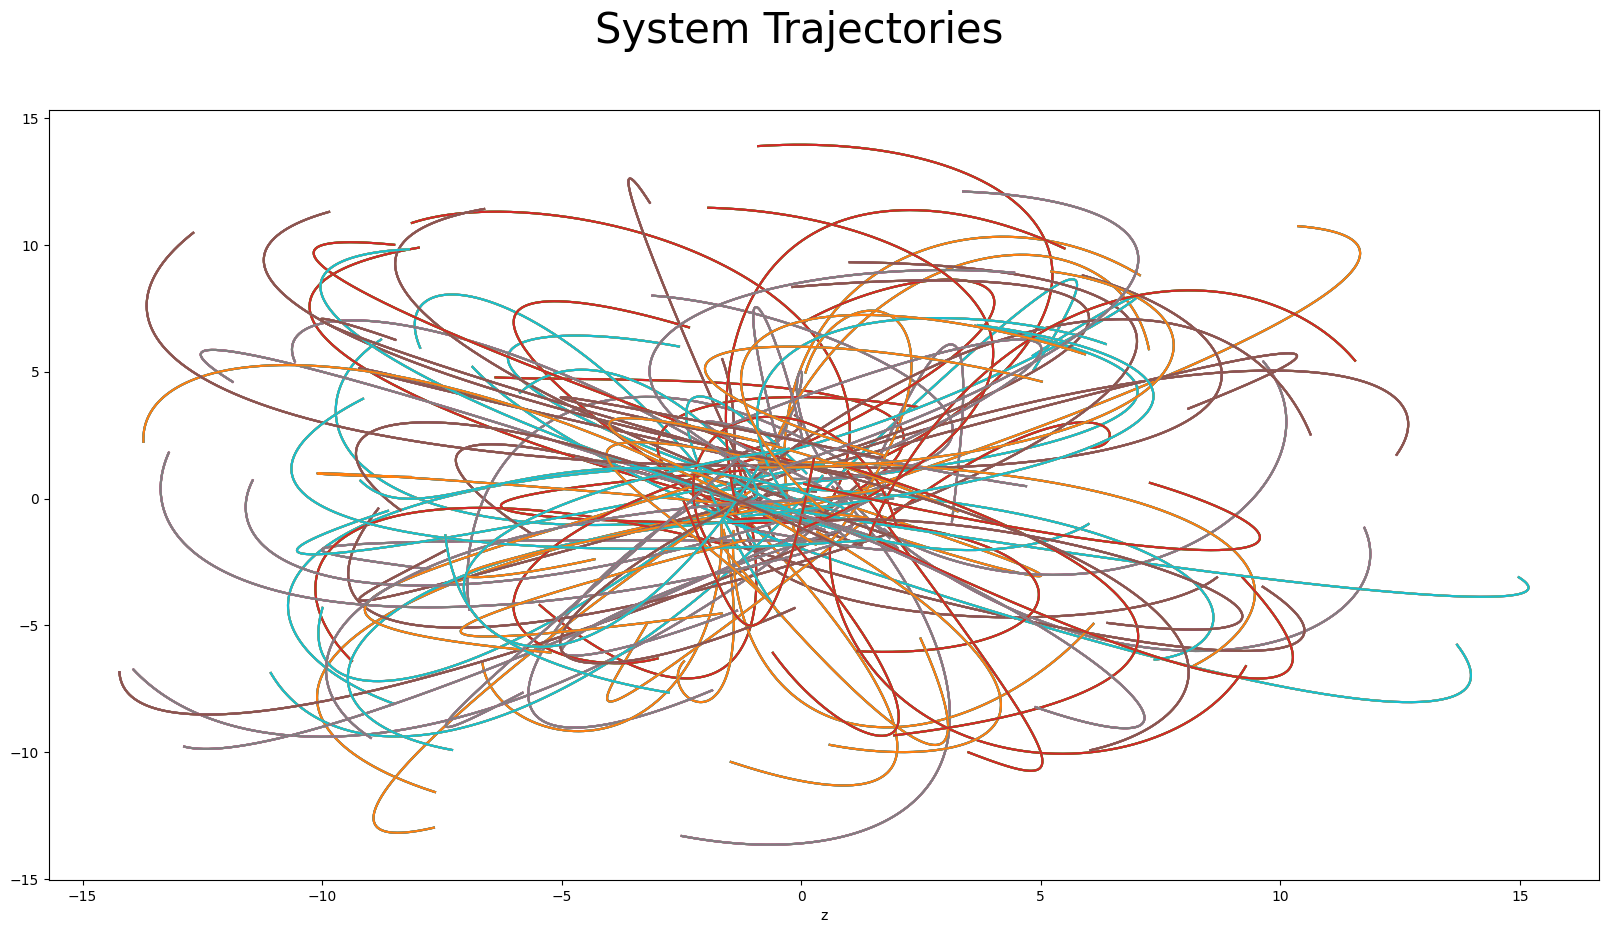

In [9]:
# Overall data
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(int(num_states)):
        plt.plot(X[j,:,0], X[j,:,1])
        plt.xlabel("y")
        plt.xlabel("z")
plt.suptitle("System Trajectories", fontsize=30)

Text(0.5, 0.98, 'Original Dynamics')

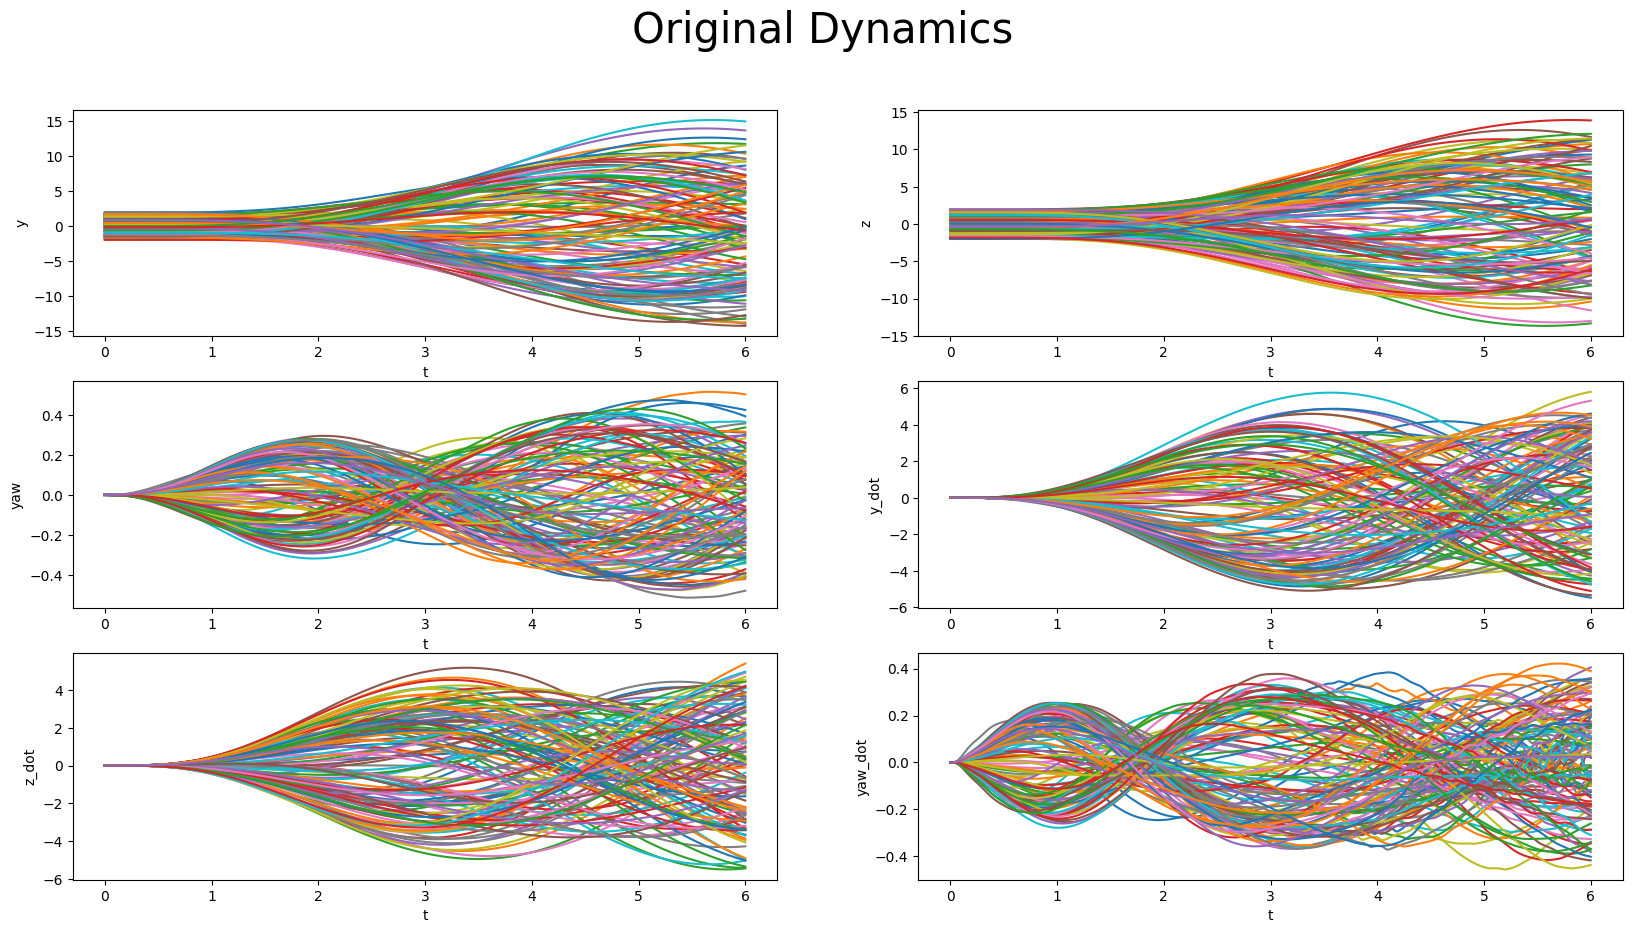

In [10]:
# Overall data
plt.figure(figsize = (20,10))
label_list = ["y", "z", "yaw", "y_dot", "z_dot", "yaw_dot"]

for j in range(num_traj):
    for i in range(int(num_states)):
        plt.subplot(3,2,i+1)
        plt.xlabel("t")
        plt.ylabel(label_list[i])
        plt.plot(T,X[j,:,i])
plt.suptitle("Original Dynamics", fontsize=30)

Text(0.5, 0.98, 'Control Inputs')

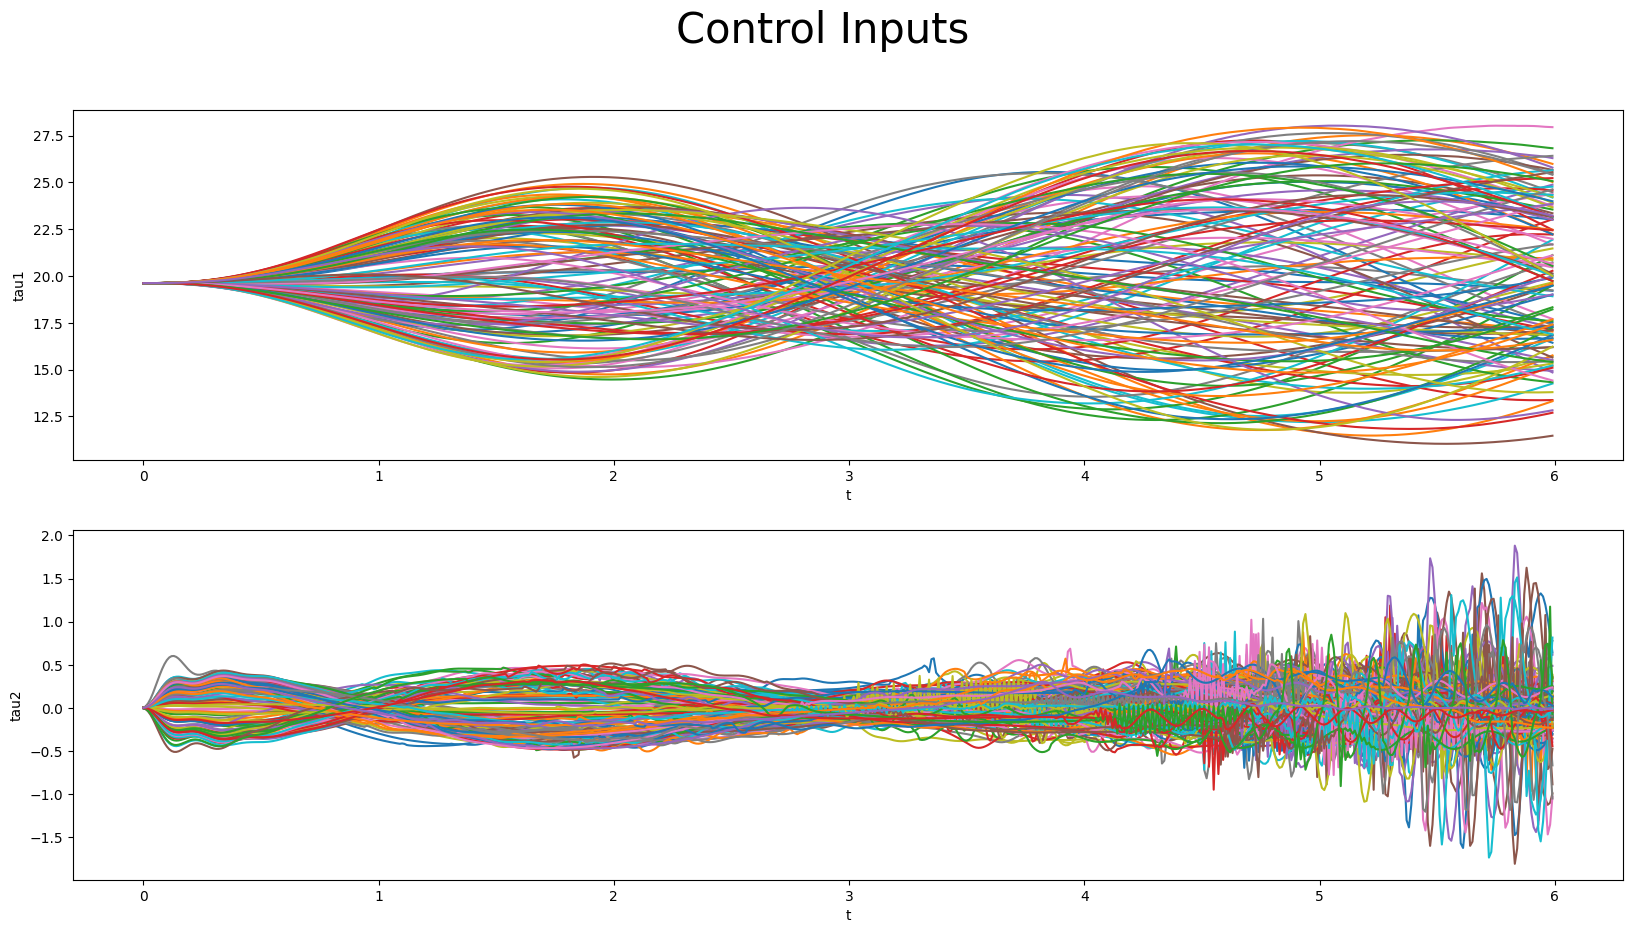

In [11]:
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(int(num_inputs)):
        plt.subplot(num_inputs,1,i+1)
        plt.xlabel("t")
        plt.ylabel("tau"+str(i+1))
        plt.plot(T[:-1],U[j,:,i])
plt.suptitle("Control Inputs", fontsize=30)

In [12]:
# split training and vaidation datasets
xs_train, us_train = X[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X[num_train:,:,:],U[num_train:,:,:]

In [13]:
# auto encoder parameters
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 20
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 5e-4 # 5e-4
net_params['epochs'] = 200
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [14]:
# Koopman Model
file = 'saved_models/planar_quad/linear/Koop_arch.pth'
if train == True:
    net = KoopmanNetCtrl_linear(net_params)
    model_koop_dnn = KoopDNN_linear(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    model_koop_dnn = torch.load(file)

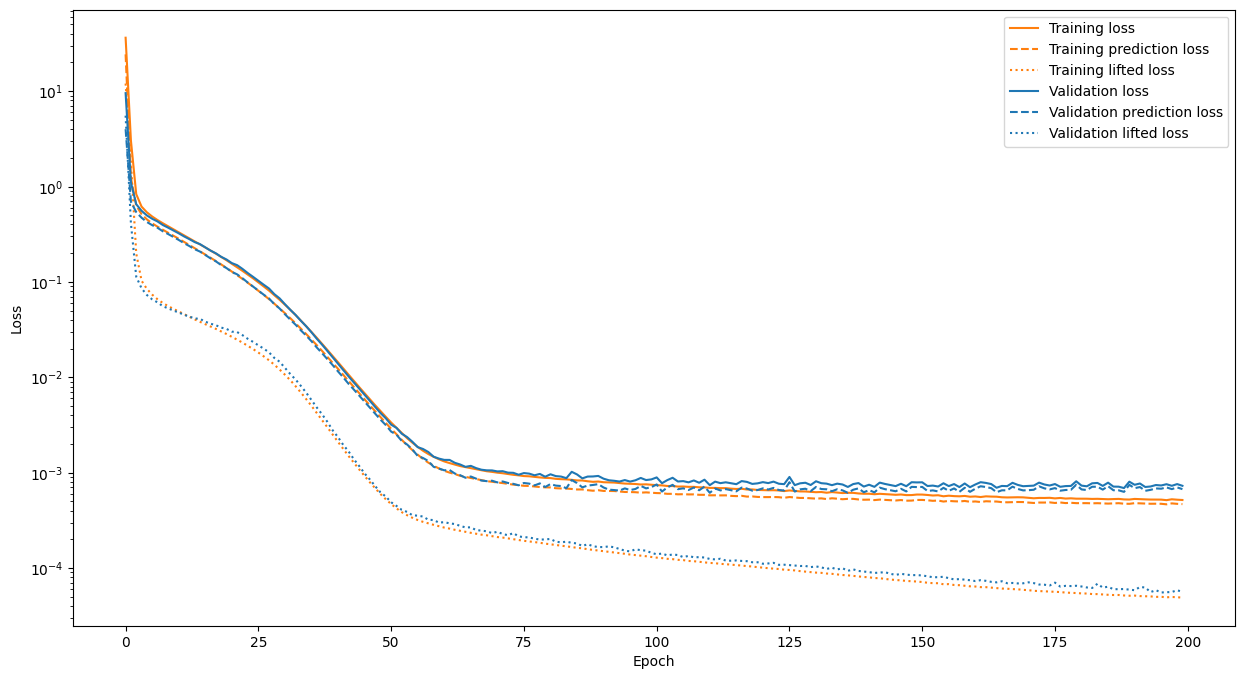

In [15]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Koopman Model Parameters

In [16]:
A = np.array(model_koop_dnn.A)
B = np.array(model_koop_dnn.B)
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(17, 17) (17, 2) (6, 17)


## Testing

In [17]:
# test data parameters
num_snaps_test = 200 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

In [18]:
# generate data
x_test = np.empty((num_traj_test,num_snaps_test+1,num_states)) # cartesian state matrix
u_test = np.empty((num_traj_test,num_snaps_test,num_inputs)) # input matrix
curr_state = []
# curr_state_noise = []
des_state = []
action_plt = []
for i in tqdm.tqdm(range(num_traj_test)):
    obs = env.reset()
    done = False
    
    # with open("/home/rajpal/koopman/linear_drone_koopman/Trajectory/traj_{}.csv".format(i+1), "w") as f:
    #     f.write("t,x,y,z,roll,pitch,yaw,vx,vy,vz,roll_rate,pitch_rate,yaw_rate,U,Mx,My,Mz\n")
         # X[i,0,:] = env.Quadrotor.get_state()
#         print(X[i,0,0],X[i,0,1],X[i,0,2],X[i,0,3],X[i,0,4],X[i,0,5],X[i,0,6],X[i,0,7],X[i,0,8],X[i,0,9],X[i,0,10],X[i,0,11])
        # f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(env.t, X[i,0,0], X[i,0,1], X[i,0,2], X[i,0,3], X[i,0,4], X[i,0,5], X[i,0,6], X[i,0,7], X[i,0,8], X[i,0,9], X[i,0,10], X[i,0,11]))

    for j in range(num_snaps_test):
        #env.render()\n",
        action = env.action_space.sample()
        #action, _states = model.predict(obs)
#             U[i,j,:] = action[0], action[1]
        obs, reward, done, info = env.step(action)
        if j == 0:
            x_test[i,j,:] = env.Quadrotor.get_state()   
        # curr_state.append(state)
        # curr_state_noise.append(state)
        # des_state.append(env.get_des_state())
        action_plt.append(env.get_action())
        # #print(action)\n",
        # print(env.get_action().reshape(-1))
        u_test[i,j,:] = env.get_action()#.reshape(-1)
        x_test[i,j+1,:] = env.Quadrotor.get_state()
            
        # f.write("{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(env.t, X[i,j+1,0], X[i,j+1,1], X[i,j+1,2], X[i,j+1,3], X[i,j+1,4], X[i,j+1,5], X[i,j+1,6], X[i,j+1,7], X[i,j+1,8], X[i,j+1,9], X[i,j+1,10], X[i,j+1,11], U[i,j,0], U[i,j,1], U[i,j,2], U[i,j,3]))
        #plot_act.append(f)
        #print(reward)
        #plot_ep.append(episode)\n",
    #print(\"Episode - {} Score - {}\".format(episode, score))\n",

        
env.close()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


In [19]:
print(x_test.shape, j)

(1, 201, 6) 199


In [20]:
# Use the preprocessing if available
X_t,_ = model_koop_dnn.net.process(x_test,data_u = u_test)

In [21]:
X_t.shape

(200, 14)

In [22]:
# flatten vector
x_t = X_t[:, :num_states]
u_t = X_t[:, num_states:num_states+num_inputs]
x_prime_t = X_t[:,num_states+num_inputs:]


print(x_t.shape, u_t.shape, x_prime_t.shape)

(200, 6) (200, 2) (200, 6)


In [23]:
# initialize states
# initialize the matricies
z_t = np.empty((n_obs,num_snaps_test)).T   #lifted state
x_est_t = np.zeros((num_states,num_snaps_test)).T #estimated values

# actual lift
z_t[0,:] = lift(x_t[0,:],model_koop_dnn, net_params)
x_est_t[0,:] = x_t[0,:]

# changed dynamics
obs = env_changed.reset()
x_actual_t = np.zeros((num_states,num_snaps_test)).T #estimated values
x_actual_t[0,:] = x_t[0,:]
env_changed.Quadrotor.state = x_actual_t[0,:]


In [24]:
for i in range(num_snaps_test-1):
  #bilinear
    z_t[i+1,:] = np.matmul(z_t[i,:],A.T)+np.matmul(u_t[i,:],B.T)
    x_est_t[i+1,:] = np.matmul(z_t[i+1,:],C.T)

    u1 = 0.5*(u_t[i, 0] - u_t[i, 1]/env_changed.L)
    u2 = 0.5*(u_t[i, 0] + u_t[i, 1]/env_changed.L)

    u1_clamped = min(max(0, u1), 30)
    u2_clamped = min(max(0, u2), 30)
    
    env_changed.Quadrotor.update(env.dt, u1_clamped, u2_clamped)
    x_actual_t[i+1,:] = env_changed.Quadrotor.get_state()

Text(0.5, 0.98, 'Testing Performance')

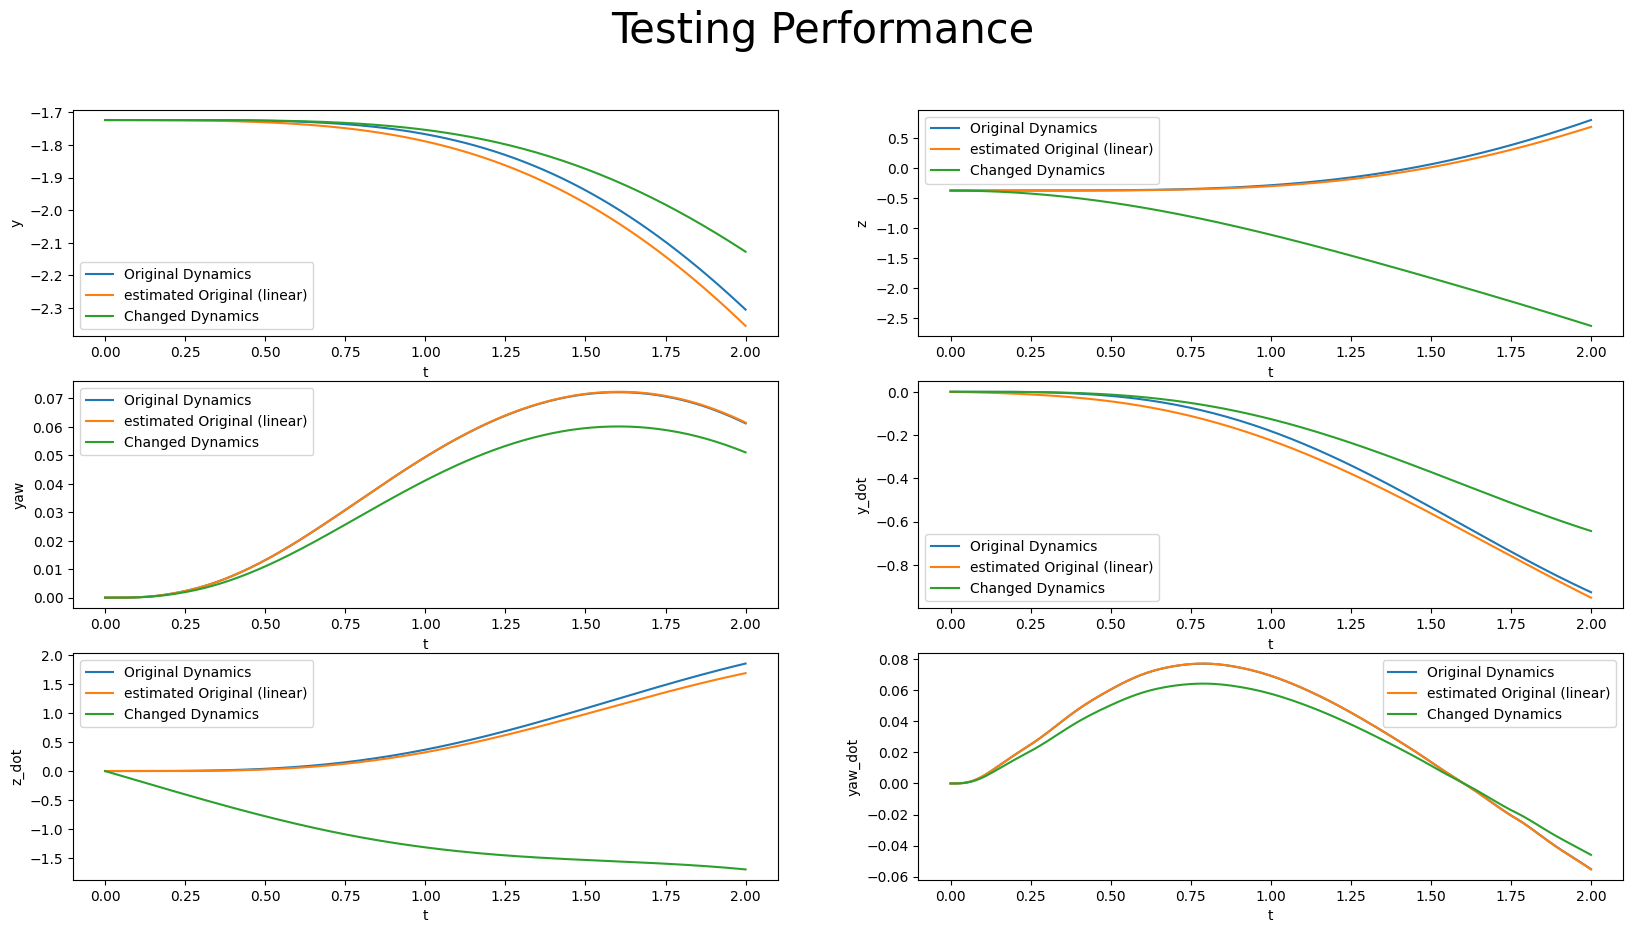

In [25]:
# state estimation evolution
plt.figure(figsize=(20, 10)) 

for i in range(num_states):
    plt.subplot(3, 2, i +1)
    plt.plot(T_test[:],x_t[:,i],label ='Original Dynamics')
    plt.plot(T_test[:],x_est_t[:,i],label = 'estimated Original (linear)')
    plt.plot(T_test[:],x_actual_t[:,i],label = 'Changed Dynamics')
    plt.xlabel('t')
    plt.ylabel(label_list[i])
    plt.legend()
plt.suptitle("Testing Performance", fontsize=30)


Text(0.5, 0.98, 'Testing Performance')

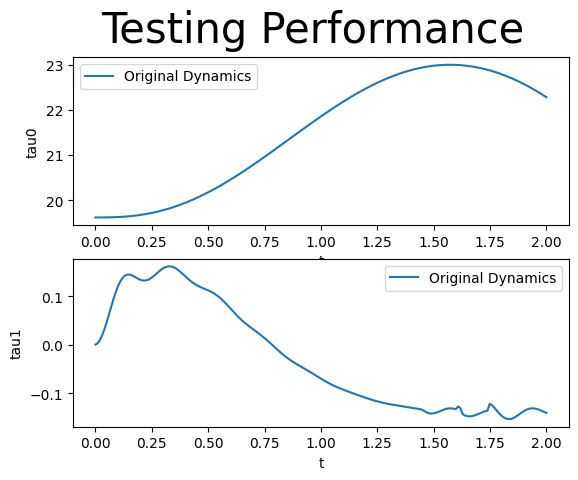

In [26]:
for i in range(num_inputs):
    plt.subplot(num_inputs, 1, i +1)
    plt.plot(T_test[:],u_t[:,i],label ='Original Dynamics')
    plt.xlabel('t')
    plt.ylabel("tau" + str(i))
    plt.legend()
plt.suptitle("Testing Performance", fontsize=30)

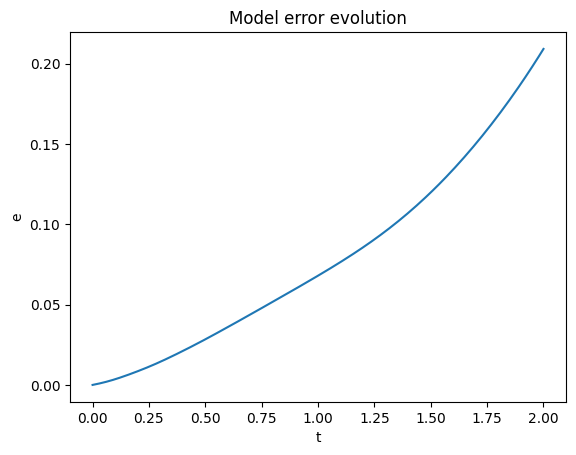

In [27]:
# error estimation
error_model_t = np.linalg.norm((x_est_t[:,:]-x_t[:,:]),axis=1)

plt.figure()
plt.plot(T_test[:],error_model_t)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

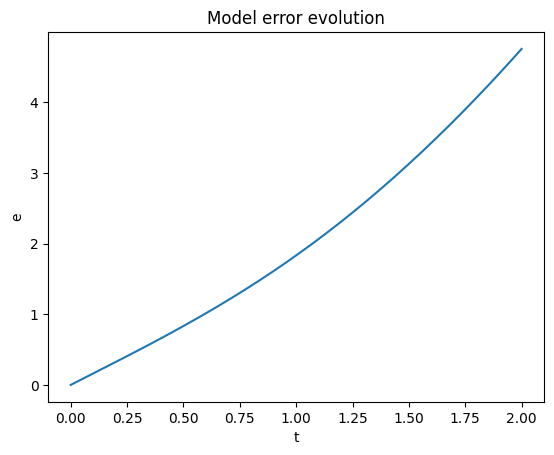

In [28]:
# error estimation
error_actual_t = np.linalg.norm((x_est_t[:,:]-x_actual_t[:,:]),axis=1)

plt.figure()
plt.plot(T_test[:],error_actual_t)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

## Controller

In [88]:
traj_length = 1000
####generate data
x_ref = np.empty((num_states, traj_length+1)) # cartesian state matrix

obs = env.reset()
done = False
    
for j in range(traj_length):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if j == 0:
        x_ref[:,j] = env.Quadrotor.get_state()   
    x_ref[:,j+1] = env.Quadrotor.get_state() 
env.close()

# x_ref = np.load('quad_path.npy')

In [89]:
x_ref.shape

(6, 1001)

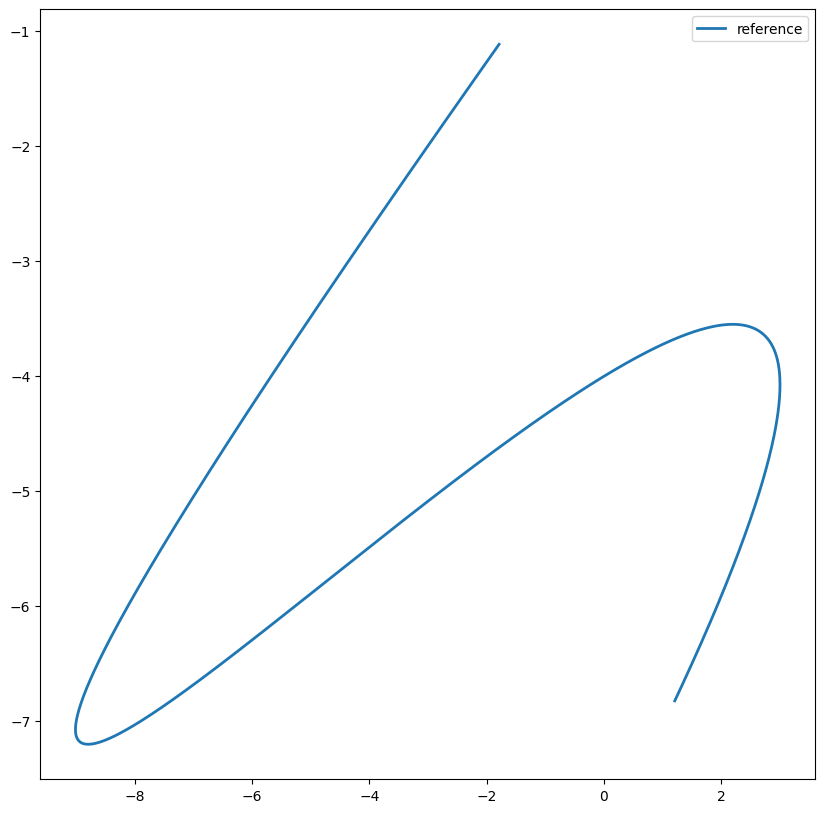

In [90]:
plt.figure(figsize=(10, 10) )
plt.plot(x_ref[0,:], x_ref[1,:], label='reference',linewidth = 2.0)
plt.legend()

In [91]:
# adaptive net parameters
adap_window = 10 #20 #hyperparameter

adapt_net_params = {}
adapt_net_params['state_dim'] = num_states
adapt_net_params['ctrl_dim'] = num_inputs
adapt_net_params['lift_dim'] = net_params["encoder_output_dim"]
adapt_net_params['optimizer'] = 'adam'
adapt_net_params['lr'] = 2e-4 # 5e-3
adapt_net_params['epochs'] = 10 #30
adapt_net_params['batch_size'] = adap_window
adapt_net_params['l2_reg'] = 1
adapt_net_params['l1_reg'] = 1
adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state
adapt_net_params['warm_start'] = False

del_A = np.zeros_like(A)
del_B = np.zeros_like(B)

adapt_net_params['del_A_prev'] = del_A
adapt_net_params['del_B_prev'] = del_B

time_delay = 0

In [92]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics
import scipy

In [93]:
# model objects for MPC
linear_model = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
linear_model_no_adapt = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
linear_model.A

<17x17 sparse matrix of type '<class 'numpy.float32'>'
	with 273 stored elements in Compressed Sparse Column format>

In [94]:
# OSQP solver setting
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-5
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [95]:
#Closed loop performance evaluation parameters:

max_iter = 1
N =  15 #length of horizon
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
# Q_mpc = 1000*scipy.sparse.diags(np.ones(num_states))    #(np.array([1, 1, 1, 1, 1, 1]))                      # State penalty matrix, trajectory generation
# QN_mpc = 200*scipy.sparse.diags(np.ones(num_states))    #(np.array([1, 1, 1, 1, 1, 1]))         # Final state penalty matrix, trajectory generation
# R_mpc = 10*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
# R0_mpc = 0*scipy.sparse.csc_matrix(np.ones(num_inputs))

Q_mpc = 1e5*scipy.sparse.diags(np.ones(num_states))    #(np.array([1, 1, 1, 1, 1, 1]))                      # State penalty matrix, trajectory generation
QN_mpc = 1e3*scipy.sparse.diags(np.ones(num_states))    #(np.array([1, 1, 1, 1, 1, 1]))         # Final state penalty matrix, trajectory generation
R_mpc = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = 0*scipy.sparse.csc_matrix(np.ones(num_inputs))

In [96]:
Q_mpc

<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements (1 diagonals) in DIAgonal format>

In [97]:
# Design trajectory:
xt = np.empty((traj_length+1, num_states))
xt[0,:] = x_ref[:,0]             # Initial value, closed loop trajectory

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
umax = 30*np.ones((num_inputs,))
umin = -umax

xmax =  20*(np.ones(num_states))    #np.array([1, 1, 1, 1, 1, 1])
xmin = -xmax

# Define initial solution for SQP algorithm:
x_init = np.linspace(xt[0,:], xt[0,:], N+1) + 0.1
u_init = 1*np.ones((num_inputs, N)).T

In [98]:
n_lift = A.shape[0]
z_init = np.empty((N+1, n_lift))
z0 = lift(xt[0,:], model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)

In [99]:
# initialize state matricies
u = np.empty((traj_length, num_inputs))
tau_adapt_app = np.empty((traj_length, num_inputs))
z_new_dyn = np.empty((n_obs, traj_length+1)).T   #lifted state
zt_old_dyn = np.empty((n_obs, traj_length+1)).T #actual lifted state
del_z_prime = np.empty((n_obs, traj_length)).T
zu_old_dyn = np.empty((n_obs*num_inputs, traj_length)).T
x_new_dyn = np.empty((num_states, traj_length+1)).T #estimated values
xt_old = np.empty((num_states, traj_length+1)).T
del_A_norm = np.zeros((traj_length,1))
del_B_norm = np.zeros((traj_length,1))

# initialize
z_new_dyn[0,:] = zt_old_dyn[0,:] = z0
x_new_dyn[0,:] = xt_old[0,:] = xt[0,:]

# initilize the env
obs = env.reset()
env.Quadrotor.state = xt[0,:]


obs_changed = env_changed.reset()
env_changed.Quadrotor.state = xt[0,:]


In [100]:
controller_nmpc_adapt = NonlinearMPCController(linear_model, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc_adapt.construct_controller(z_init, u_init, x_ref[:,0])

In [101]:
total_time = 0

for i in range(traj_length):
  # incorrect dynamics
    start_time = time.time()
    z_new_dyn[i,:] = lift(x_new_dyn[i,:], model_koop_dnn, net_params)
    
    del_z_prime[i,:] = z_new_dyn[i,:] - zt_old_dyn[i,:]
    zu_old_dyn[i,:] = np.kron(u[i,:], zt_old_dyn[i,:])

    if i < adap_window + 1 :
        del_A = np.zeros_like(A)
        del_B = np.zeros_like(B)
    else:
        del_Z_prime = del_z_prime[i-adap_window:i,:].T
        Z_old = zt_old_dyn[i-(adap_window+1):i-1].T
        U_old = u[i-(adap_window+1):i-1].T

        #invoke neural net for adapation
        adapt_network = AdaptNet_linear(adapt_net_params)

        adapt_network.model_pipeline(Z_old, U_old, del_Z_prime, print_epoch = True)

        del_A, del_B = adapt_network.get_del_matrices()

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)

    # linear_model.A = scipy.sparse.csc_matrix(A + del_A)
    # linear_model.B = scipy.sparse.csc_matrix(B + del_B)

    linear_model.A = scipy.sparse.csc_matrix(linear_model.A.toarray() + del_A)
    linear_model.B = scipy.sparse.csc_matrix(linear_model.B.toarray() + del_B)

    
    controller_nmpc_adapt.solve_to_convergence(x_ref[:,i+1], z_new_dyn[i,:], controller_nmpc_adapt.z_init, controller_nmpc_adapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_adapt.update_initial_guess_()
    u[i,:] = controller_nmpc_adapt.cur_u[0,:]
    end_time = time.time()

    total_time = total_time + end_time-start_time
    
    if sum(np.isnan(u[i,:])) > 0:
        break

    # adapted model
    zt_old_dyn[i+1,:] = controller_nmpc_adapt.z_N0
    #zt_old_dyn[i+1,:] = np.matmul(z_new_dyn[i,:],A.T+del_A.T)+np.matmul(u[i,:],B.T+del_B.T)
    xt[i+1,:] = np.matmul(zt_old_dyn[i+1,:],C.T)
    
    
    u1 = 0.5*(u[i, 0] - u[i, 1]/env.L)
    u2 = 0.5*(u[i, 0] + u[i, 1]/env.L)

    u1_clamped = min(max(0, u1), 30)
    u2_clamped = min(max(0, u2), 30)
    
    env.Quadrotor.update(env.dt, u1_clamped, u2_clamped)
    
    xt_old[i+1,:] = env.Quadrotor.get_state() 
    
    end_time = time.time()

    total_time = total_time + end_time-start_time

   


    total_time = total_time + end_time-start_time

    u1 = 0.5*(u[i, 0] - u[i, 1]/env_changed.L)
    u2 = 0.5*(u[i, 0] + u[i, 1]/env_changed.L)

    u1_clamped = min(max(0, u1), 30)
    u2_clamped = min(max(0, u2), 30)
    
    env_changed.Quadrotor.update(env.dt, u1_clamped, u2_clamped)
    


    x_new_dyn[i+1,:] = env_changed.Quadrotor.get_state() 
    
    adapt_net_params['del_A_prev'] = del_A
    adapt_net_params['del_B_prev'] = del_B
    

print('Time Taken', total_time)

ValueError: OSQP did not solve the problem!

In [ ]:
print('iterations',i , 'time_per_iter = ', total_time/i)

In [ ]:
#controller that works on old model (unadapted)
N_noadapt = N #length of horizon
Q_mpc_noadapt = 1e5*scipy.sparse.diags(np.array([1, 1, 0.1, 1, 1, 0.1]))                       # State penalty matrix, trajectory generation
QN_mpc_noadapt = 1e3*scipy.sparse.diags(np.array([1, 1, 0.1, 1, 1, 0.1]))         # Final state penalty matrix, trajectory generation
R_mpc_noadapt = 10*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc_noadapt = 0*scipy.sparse.csc_matrix(np.ones(num_inputs))

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
umax_noadapt = 30*np.ones((num_inputs,))
umin_noadapt = -umax

xmax_noadapt =  20*np.ones((num_states,))
xmin_noadapt = -xmax

In [ ]:
controller_nmpc_noadapt = NonlinearMPCController(linear_model_no_adapt, N_noadapt, dt, umin_noadapt, umax_noadapt, xmin_noadapt, xmax_noadapt, Q_mpc_noadapt, R_mpc_noadapt, QN_mpc_noadapt, solver_settings)
controller_nmpc_noadapt.construct_controller(z_init, u_init, x_ref[:,0])
# controller_nmpc_noadapt.trajectory_tracking(xt[0,:], z0, x_ref.T, max_iter)

In [ ]:
xt_no_adapt = np.empty((num_states,traj_length+1)).T
x_new_noadapt = np.empty((num_states,traj_length+1)).T
xt_no_adapt[0,:] = x_new_noadapt[0,:] = xt[0,:]
u_no_adapt = np.empty((num_inputs, traj_length)).T
tau_no_adapt_app = np.empty((num_inputs, traj_length)).T
z_no_adapt = np.empty((n_obs, traj_length+1)).T

obs = env.reset()
env.Quadrotor.state = xt[0,:]


obs_changed = env_changed.reset()
env_changed.Quadrotor.state = xt[0,:]

total_time = 0
for i in range(traj_length):
    # incorrect dynamics
    start_time = time.time()
    z_no_adapt[i,:] = lift(x_new_noadapt[i,:], model_koop_dnn, net_params)

    controller_nmpc_noadapt.solve_to_convergence(x_ref[:,i+1], z_no_adapt[i,:], controller_nmpc_noadapt.z_init, controller_nmpc_noadapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_noadapt.update_initial_guess_()
    u_no_adapt[i,:] = controller_nmpc_noadapt.cur_u[0,:] 
    end_time = time.time()
    total_time = total_time + end_time-start_time

    if sum(np.isnan(u_no_adapt[i,:])) > 0:
        break
    
    
    xt_no_adapt[i+1,:] = np.matmul(controller_nmpc_noadapt.z_N0, C.T)
    

    
    u1 = 0.5*(u_no_adapt[i, 0] - u_no_adapt[i, 1]/env_changed.L)
    u2 = 0.5*(u_no_adapt[i, 0] + u_no_adapt[i, 1]/env_changed.L)

    u1_clamped = min(max(0, u1), 30)
    u2_clamped = min(max(0, u2), 30)
    
    env_changed.Quadrotor.update(env.dt, u1_clamped, u2_clamped)
    
    x_new_noadapt[i+1,:] = env_changed.Quadrotor.get_state() 
    
print('Time Taken', total_time)

In [ ]:
i

In [ ]:
print('iterations',i ,'time_per_iter = ', total_time/i)

In [ ]:
plt.figure(figsize=(10, 10) )
plt.plot(x_ref[0,0], x_ref[1,0],'c*', label='start_point',linewidth = 6.0)
plt.plot(x_new_dyn[:,0], x_new_dyn[:,1], label='path traced (adaptation)',linewidth = 2.0)
plt.plot(x_new_noadapt[:,0], x_new_noadapt[:,1], label='path traced (nominal)',linewidth = 2.0)
plt.plot(x_ref[0,:], x_ref[1,:], label='reference',linewidth = 2.0)
plt.legend()

In [ ]:
plt.figure(figsize=(20, 10) )
for i in range(num_states):
    plt.subplot(3,2,i+1)
    plt.plot(t_eval, x_new_dyn[:,i], label='path traced(adapt)',linewidth = 2.0)
    plt.plot(t_eval, x_new_noadapt[:,i], label='path traced(no adapt)',linewidth = 2.0)
    plt.plot(t_eval, x_ref[i,:], label="reference",linewidth = 2.0)
    plt.xlabel('t')
    plt.ylabel(label_list[i])
    plt.legend()

In [ ]:
plt.figure(figsize=(20, 10) )
for i in range(num_inputs):
    plt.subplot(2,2,2*i+1)
    plt.plot(t_eval[:-1], u[:,i], label='Adaptive',linewidth = 2.0)
    plt.xlabel('t')
    plt.legend()
    plt.ylabel(label_list[i])

    plt.subplot(2,2,2*i+2)
    plt.plot(t_eval[:-1], u_no_adapt[:,i], label='Nominal',linewidth = 2.0)
    plt.xlabel('t')
    plt.ylabel(label_list[i])

    
    plt.legend()

In [ ]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(t_eval[:-1],del_A_norm)
plt.xlabel('t')
plt.ylabel('||del_A||')
plt.title(" ||del_A|| Evolution")

plt.subplot(1,2,2)
plt.plot(t_eval[:-1],del_B_norm)
plt.xlabel('t')
plt.ylabel('||del_B||')
plt.title("||del_B|| Evolution")

In [ ]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(t_eval[:-1],del_A_norm/np.linalg.norm(A))
plt.xlabel('t')
plt.ylabel('||del_A||/||A||')
plt.title(" ||del_A||/||A|| Evolution")

plt.subplot(1,2,2)
plt.plot(t_eval[:-1],del_B_norm/np.linalg.norm(A))
plt.xlabel('t')
plt.ylabel('||del_B||/|||B||')
plt.title("||del_B||/||B|| Evolution")

In [ ]:
error_dynamics_pos_adapt = np.linalg.norm((x_new_dyn[:,:2].T-x_ref[:2,:]),axis=0)
error_dynamics_pos_no_adapt = np.linalg.norm((x_new_noadapt[:,:2].T-x_ref[:2,:]),axis=0)


plt.figure(figsize = (20,10))

plt.plot(t_eval,error_dynamics_pos_adapt, label = 'Adapt')
plt.plot(t_eval,error_dynamics_pos_no_adapt, label = 'No Adapt')
plt.title("Position RMSE Comparison")
plt.xlabel('t')
plt.ylabel('error')
plt.legend()



In [ ]:
error_dynamics_adapt = np.linalg.norm((x_new_dyn.T-x_ref),axis=0)
error_dynamics_no_adapt = np.linalg.norm((x_new_noadapt.T-x_ref),axis=0)

plt.figure(figsize = (20,10))

plt.plot(t_eval,error_dynamics_adapt, label = 'Adapt')
plt.plot(t_eval,error_dynamics_no_adapt, label = 'No Adapt')
plt.title("State RMSE Comparison")

plt.xlabel('t')
plt.ylabel('error')
plt.legend()

In [ ]:
error_dynamics_adapt_rmse = np.linalg.norm(error_dynamics_adapt)/np.sqrt(t_eval.shape[0])
error_dynamics_no_adapt_rmse = np.linalg.norm(error_dynamics_no_adapt)/np.sqrt(t_eval.shape[0])

error_dynamics_pos_adapt_rmse = np.linalg.norm(error_dynamics_pos_adapt)/np.sqrt(t_eval.shape[0])
error_dynamics_pos_no_adapt_rmse = np.linalg.norm(error_dynamics_pos_no_adapt)/np.sqrt(t_eval.shape[0])

print("RMSE Positional Error in Adaptive Model", error_dynamics_pos_adapt_rmse)
print("RMSE Error in Adaptive Model", error_dynamics_adapt_rmse)
print("RMSE Positional Error in Non-Adaptive Model", error_dynamics_pos_no_adapt_rmse)
print("RMSE Error in Non-Adaptive Model", error_dynamics_no_adapt_rmse)

In [ ]:
plt.figure(figsize=(10, 10) )

plt.plot(x_new_dyn[:,0], x_new_dyn[:,1], label='path traced (adaptation)',linewidth = 2.0)
plt.plot(x_new_noadapt[:,0], x_new_noadapt[:,1], label='path traced (nominal)',linewidth = 2.0)
plt.plot(x_ref[0,:], x_ref[1,:], label='reference',linewidth = 2.0)
plt.legend()
plt.savefig('lin_adap_quad_path')